<a href="https://colab.research.google.com/github/matan72/adv_dl_project/blob/part_a/part_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import kagglehub
import pandas as pd
import plotly.express as px

In [ ]:
data_path = kagglehub.dataset_download("datatattle/covid-19-nlp-text-classification")

print("Path to dataset files:", data_path)


Path to dataset files: /kaggle/input/covid-19-nlp-text-classification


In [ ]:
train_df = pd.read_csv(os.path.join(data_path, "Corona_NLP_train.csv"), encoding="latin1")
test_df = pd.read_csv(os.path.join(data_path, "Corona_NLP_test.csv"), encoding="latin1")

In [ ]:
print(train_df.shape, test_df.shape)

(41157, 6) (3798, 6)


Null count

In [ ]:
train_df.isna().sum()

,0
UserName,0
ScreenName,0
Location,8590
TweetAt,0
OriginalTweet,0
Sentiment,0


Seems that only location has null values. So, for visualizations involving location, we'll remove them.

Number of unique classes:

In [ ]:
train_df['Sentiment'].value_counts().index

Index(['Positive', 'Negative', 'Neutral', 'Extremely Positive',
       'Extremely Negative'],
      dtype='object', name='Sentiment')

In [ ]:
sentiment_counts = train_df['Sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']
fig = px.pie(sentiment_counts, values='Count', names='Sentiment', title='Distribution of Sentiments in Training Data', hole=0.4)
fig.show()

5 classes, seems quite balanced, if we see a bias towords the classes "positive" and "negative" we will have to consider weighted loss approch

# Visualizations

## 1. Sentiment VS Geographical location

Clean dataframe for visualiations regarding location

In [ ]:
SENTIMENT_TO_SCORE_MAPPING = {
    'Extremely Negative': -2,
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1,
    'Extremely Positive': 2
    }

In [ ]:
location_viz_df = train_df[~train_df["Location"].isna()]
location_viz_df["sentiment_score"] = location_viz_df["Sentiment"].map(SENTIMENT_TO_SCORE_MAPPING)

<ipython-input-9-68b6f35e4f20>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
LOCATION_IQ_TOKEN = 'pk.141e2e5711ccfbe2bea40ef7e857c721'
SAMPLE_SIZE = 300 # because of a ratelimit to the API - maximum 5K / day

In [ ]:
map_viz_df = location_viz_df.sample(SAMPLE_SIZE, random_state=23)

In [ ]:
import requests
import time
from tqdm import tqdm

def geocode_locationiq(location):
    url = "https://us1.locationiq.com/v1/search.php"
    params = {
        "key": LOCATION_IQ_TOKEN,
        "q": location,
        "format": "json"
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        if isinstance(data, list) and data:
            return float(data[0]['lat']), float(data[0]['lon'])
        else:
            return None, None
    except Exception as e:
        print(f"Error geocoding {location}: {e}")
        return None, None

# Apply with a delay to avoid rate limits (optional, but safe)
results = []
for loc in tqdm(map_viz_df['Location']):
    lat, lon = geocode_locationiq(loc)
    results.append((lat, lon))
    time.sleep(0.5)  # Optional throttle (LocationIQ free tier = 2 req/sec)

# Split the results into new columns
map_viz_df[['latitude', 'longitude']] = pd.DataFrame(results, index=map_viz_df.index)


 13%|█▎        | 39/300 [00:27<02:56,  1.48it/s]

Error geocoding ?????: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=%3F%3F%3F%3F%3F&format=json


 30%|███       | 90/300 [01:03<02:23,  1.46it/s]

Error geocoding Detroit: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Detroit&format=json


 30%|███       | 91/300 [01:03<02:20,  1.49it/s]

Error geocoding Quezon City, Philippines: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Quezon+City%2C+Philippines&format=json


 31%|███       | 92/300 [01:04<02:17,  1.52it/s]

Error geocoding Norfolk, UK: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Norfolk%2C+UK&format=json


 31%|███       | 93/300 [01:04<02:15,  1.53it/s]

Error geocoding Ottawa: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Ottawa&format=json


 31%|███▏      | 94/300 [01:05<02:13,  1.54it/s]

Error geocoding Ithaca, NY: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Ithaca%2C+NY&format=json


 32%|███▏      | 95/300 [01:06<02:12,  1.55it/s]

Error geocoding www.fucktrump.com: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=www.fucktrump.com&format=json


 32%|███▏      | 96/300 [01:06<02:12,  1.54it/s]

Error geocoding Avusturya, Viyana: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Avusturya%2C+Viyana&format=json


 32%|███▏      | 97/300 [01:07<02:10,  1.55it/s]

Error geocoding Kuala Lumpur-Sepang-Melaka: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Kuala+Lumpur-Sepang-Melaka&format=json


 33%|███▎      | 98/300 [01:08<02:11,  1.54it/s]

Error geocoding Calgary, Alberta, Canada: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Calgary%2C+Alberta%2C+Canada&format=json


 33%|███▎      | 99/300 [01:08<02:12,  1.51it/s]

Error geocoding Chicago, IL: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Chicago%2C+IL&format=json


 33%|███▎      | 100/300 [01:09<02:10,  1.53it/s]

Error geocoding Dublin: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Dublin&format=json


 34%|███▎      | 101/300 [01:10<02:08,  1.55it/s]

Error geocoding Mumbai: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Mumbai&format=json


 34%|███▍      | 102/300 [01:10<02:08,  1.54it/s]

Error geocoding Detroit: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Detroit&format=json


 34%|███▍      | 103/300 [01:11<02:07,  1.55it/s]

Error geocoding Brooklyn, NY: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Brooklyn%2C+NY&format=json


 35%|███▍      | 104/300 [01:12<02:05,  1.56it/s]

Error geocoding Oklahoma City, OK: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Oklahoma+City%2C+OK&format=json


 35%|███▌      | 105/300 [01:12<02:03,  1.57it/s]

Error geocoding Norway: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Norway&format=json


 35%|███▌      | 106/300 [01:13<02:03,  1.57it/s]

Error geocoding Mid-Michigan: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Mid-Michigan&format=json


 36%|███▌      | 107/300 [01:13<02:02,  1.58it/s]

Error geocoding Cardiff: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Cardiff&format=json


 36%|███▌      | 108/300 [01:14<02:01,  1.58it/s]

Error geocoding Research associate at IsAG: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Research+associate+at+IsAG&format=json


 36%|███▋      | 109/300 [01:15<02:01,  1.57it/s]

Error geocoding Verona, WI: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Verona%2C+WI&format=json


 37%|███▋      | 110/300 [01:15<02:00,  1.58it/s]

Error geocoding Argadahana: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Argadahana&format=json


 37%|███▋      | 111/300 [01:16<02:00,  1.57it/s]

Error geocoding Ipswich, England: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Ipswich%2C+England&format=json


 37%|███▋      | 112/300 [01:17<01:59,  1.57it/s]

Error geocoding Sheffield: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Sheffield&format=json


 38%|███▊      | 113/300 [01:17<02:02,  1.52it/s]

Error geocoding Seoul, South Korea: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Seoul%2C+South+Korea&format=json


 38%|███▊      | 114/300 [01:18<02:01,  1.53it/s]

Error geocoding New York, NJ, Los Angeles: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=New+York%2C+NJ%2C+Los+Angeles&format=json


 38%|███▊      | 115/300 [01:19<02:00,  1.54it/s]

Error geocoding Delhi, India: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Delhi%2C+India&format=json


 39%|███▊      | 116/300 [01:19<02:00,  1.53it/s]

Error geocoding Singapore: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Singapore&format=json


 39%|███▉      | 117/300 [01:20<01:58,  1.55it/s]

Error geocoding Chicago, IL: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Chicago%2C+IL&format=json


 40%|████      | 120/300 [01:22<01:59,  1.50it/s]

Error geocoding ??: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=%3F%3F&format=json


 49%|████▉     | 147/300 [01:41<01:43,  1.49it/s]

Error geocoding News & Bible verses USA: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=News+%26+Bible+verses+USA&format=json


 51%|█████▏    | 154/300 [01:46<01:40,  1.45it/s]

Error geocoding deep in cognitive dissonance: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=deep+in+cognitive+dissonance&format=json


 54%|█████▍    | 162/300 [01:51<01:34,  1.46it/s]

Error geocoding Retweet doesnÂt = endorsement: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Retweet+doesn%C3%82%C2%92t+%3D+endorsement&format=json


 59%|█████▉    | 178/300 [02:02<01:24,  1.44it/s]

Error geocoding Manchester, United Kingdom: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Manchester%2C+United+Kingdom&format=json


 60%|█████▉    | 179/300 [02:03<01:21,  1.49it/s]

Error geocoding Try Ur Luck...Guess: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Try+Ur+Luck...Guess&format=json


 60%|██████    | 180/300 [02:03<01:19,  1.51it/s]

Error geocoding Westminster, United Kingdom: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Westminster%2C+United+Kingdom&format=json


 60%|██████    | 181/300 [02:04<01:17,  1.53it/s]

Error geocoding Punjab, Pakistan: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Punjab%2C+Pakistan&format=json


 61%|██████    | 182/300 [02:05<01:16,  1.54it/s]

Error geocoding Earth: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Earth&format=json


 61%|██████    | 183/300 [02:05<01:15,  1.55it/s]

Error geocoding USA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=USA&format=json


 61%|██████▏   | 184/300 [02:06<01:14,  1.56it/s]

Error geocoding Tempe, AZ ?? ? Vancity ??: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Tempe%2C+AZ+%3F%3F+%3F+Vancity+%3F%3F&format=json


 62%|██████▏   | 185/300 [02:07<01:13,  1.57it/s]

Error geocoding Philadelphia, PA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Philadelphia%2C+PA&format=json


 62%|██████▏   | 186/300 [02:07<01:12,  1.57it/s]

Error geocoding Andover United Kingdom: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Andover+United+Kingdom&format=json


 62%|██████▏   | 187/300 [02:08<01:12,  1.57it/s]

Error geocoding Ntare, Muti Lane  Mbarara: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Ntare%2C+Muti+Lane++Mbarara&format=json


 63%|██████▎   | 188/300 [02:09<01:11,  1.57it/s]

Error geocoding Victoria, Australia: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Victoria%2C+Australia&format=json


 63%|██████▎   | 189/300 [02:09<01:10,  1.57it/s]

Error geocoding Japan: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Japan&format=json


 63%|██████▎   | 190/300 [02:10<01:10,  1.57it/s]

Error geocoding PNW: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=PNW&format=json


 64%|██████▎   | 191/300 [02:10<01:09,  1.58it/s]

Error geocoding Los Angeles, CA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Los+Angeles%2C+CA&format=json


 64%|██████▍   | 192/300 [02:11<01:08,  1.57it/s]

Error geocoding Washington, DC: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Washington%2C+DC&format=json


 64%|██████▍   | 193/300 [02:12<01:07,  1.58it/s]

Error geocoding Dublin, Ireland: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Dublin%2C+Ireland&format=json


 65%|██████▍   | 194/300 [02:12<01:07,  1.57it/s]

Error geocoding On a ball in space: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=On+a+ball+in+space&format=json


 65%|██████▌   | 195/300 [02:13<01:07,  1.57it/s]

Error geocoding Global: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Global&format=json


 65%|██████▌   | 196/300 [02:14<01:06,  1.56it/s]

Error geocoding Monroe, MI: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Monroe%2C+MI&format=json


 66%|██████▌   | 197/300 [02:14<01:06,  1.55it/s]

Error geocoding goa india: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=goa+india&format=json


 66%|██████▌   | 198/300 [02:15<01:05,  1.56it/s]

Error geocoding Peterborough, Ontario: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Peterborough%2C+Ontario&format=json


 66%|██████▋   | 199/300 [02:16<01:04,  1.57it/s]

Error geocoding Lagos, Nigeria: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Lagos%2C+Nigeria&format=json


 67%|██████▋   | 200/300 [02:16<01:03,  1.57it/s]

Error geocoding Ffestiniog.: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Ffestiniog.&format=json


 67%|██████▋   | 201/300 [02:17<01:02,  1.58it/s]

Error geocoding Enfield, London: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Enfield%2C+London&format=json


 67%|██████▋   | 202/300 [02:17<01:01,  1.58it/s]

Error geocoding Patna, Bihar, India: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Patna%2C+Bihar%2C+India&format=json


 68%|██████▊   | 203/300 [02:18<01:01,  1.59it/s]

Error geocoding UK : 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=UK+&format=json


 68%|██████▊   | 204/300 [02:19<01:00,  1.58it/s]

Error geocoding Africa ?: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Africa+%3F&format=json


 68%|██████▊   | 205/300 [02:19<01:00,  1.57it/s]

Error geocoding Mars: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Mars&format=json


 69%|██████▊   | 206/300 [02:20<00:59,  1.57it/s]

Error geocoding New York, USA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=New+York%2C+USA&format=json


 71%|███████   | 213/300 [02:25<00:59,  1.47it/s]

Error geocoding Crenshaw X Slauson Ave = The District: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Crenshaw+X+Slauson+Ave+%3D+The+District&format=json


 74%|███████▎  | 221/300 [02:30<00:53,  1.47it/s]

Error geocoding @literary.libations on Instagr: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=%40literary.libations+on+Instagr&format=json


 81%|████████  | 242/300 [02:45<00:37,  1.53it/s]

Error geocoding Playing Cool Games Since ATARI: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Playing+Cool+Games+Since+ATARI&format=json


 81%|████████▏ | 244/300 [02:46<00:37,  1.50it/s]

Error geocoding info@aptitudeconsulting.co.za: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=info%40aptitudeconsulting.co.za&format=json


 82%|████████▏ | 245/300 [02:47<00:36,  1.51it/s]

Error geocoding WestMonster: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=WestMonster&format=json


 87%|████████▋ | 260/300 [02:57<00:27,  1.47it/s]

Error geocoding Planeptune: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Planeptune&format=json


 89%|████████▉ | 267/300 [03:02<00:23,  1.43it/s]

Error geocoding Manhattan, NY: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Manhattan%2C+NY&format=json


 89%|████████▉ | 268/300 [03:02<00:21,  1.48it/s]

Error geocoding San Francisco, CA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=San+Francisco%2C+CA&format=json


 90%|████████▉ | 269/300 [03:03<00:20,  1.51it/s]

Error geocoding London, England: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=London%2C+England&format=json


 90%|█████████ | 270/300 [03:04<00:19,  1.52it/s]

Error geocoding City of London, London: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=City+of+London%2C+London&format=json


 90%|█████████ | 271/300 [03:04<00:18,  1.54it/s]

Error geocoding Raleigh, NC: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Raleigh%2C+NC&format=json


 91%|█████████ | 272/300 [03:05<00:17,  1.56it/s]

Error geocoding Orillia, Ontario : 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Orillia%2C+Ontario+&format=json


 91%|█████████ | 273/300 [03:05<00:17,  1.57it/s]

Error geocoding Mississippi: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Mississippi&format=json


 91%|█████████▏| 274/300 [03:06<00:16,  1.57it/s]

Error geocoding Tallahassee, FL: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Tallahassee%2C+FL&format=json


 92%|█████████▏| 275/300 [03:07<00:15,  1.57it/s]

Error geocoding United States: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=United+States&format=json


 92%|█████████▏| 276/300 [03:07<00:15,  1.54it/s]

Error geocoding Cardiff, Wales: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Cardiff%2C+Wales&format=json


 92%|█████████▏| 277/300 [03:08<00:14,  1.55it/s]

Error geocoding Ottawa, ON: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Ottawa%2C+ON&format=json


 93%|█████████▎| 278/300 [03:09<00:14,  1.54it/s]

Error geocoding Follow Dance Studio & Arts: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Follow+Dance+Studio+%26+Arts&format=json


 93%|█████████▎| 279/300 [03:09<00:13,  1.55it/s]

Error geocoding Colorado Springs: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Colorado+Springs&format=json


 93%|█████████▎| 280/300 [03:10<00:12,  1.55it/s]

Error geocoding Arizona, USA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Arizona%2C+USA&format=json


 94%|█████████▎| 281/300 [03:11<00:12,  1.55it/s]

Error geocoding Durban, South Africa: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Durban%2C+South+Africa&format=json


 94%|█████████▍| 282/300 [03:11<00:11,  1.56it/s]

Error geocoding Poway, CA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Poway%2C+CA&format=json


 94%|█████████▍| 283/300 [03:12<00:10,  1.56it/s]

Error geocoding nowhere in particular: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=nowhere+in+particular&format=json


 95%|█████████▍| 284/300 [03:13<00:10,  1.57it/s]

Error geocoding Singapore: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Singapore&format=json


 95%|█████████▌| 285/300 [03:13<00:09,  1.58it/s]

Error geocoding Pasadena, CA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Pasadena%2C+CA&format=json


 95%|█████████▌| 286/300 [03:14<00:09,  1.56it/s]

Error geocoding 1021|Msawuden : 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=1021%7CMsawuden+&format=json


 96%|█████████▌| 287/300 [03:14<00:08,  1.55it/s]

Error geocoding New York, NY: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=New+York%2C+NY&format=json


 96%|█████████▌| 288/300 [03:15<00:07,  1.55it/s]

Error geocoding Lincolnshire: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Lincolnshire&format=json


 96%|█████████▋| 289/300 [03:16<00:07,  1.55it/s]

Error geocoding London, Canada: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=London%2C+Canada&format=json


 97%|█████████▋| 290/300 [03:16<00:06,  1.56it/s]

Error geocoding Hong Kong: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Hong+Kong&format=json


 97%|█████████▋| 291/300 [03:17<00:05,  1.56it/s]

Error geocoding Champaign, IL: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Champaign%2C+IL&format=json


 97%|█████████▋| 292/300 [03:18<00:05,  1.56it/s]

Error geocoding Cape Town, South Africa: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Cape+Town%2C+South+Africa&format=json


 98%|█████████▊| 293/300 [03:18<00:04,  1.57it/s]

Error geocoding Cincinnati, OH: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Cincinnati%2C+OH&format=json


 98%|█████████▊| 294/300 [03:19<00:03,  1.56it/s]

Error geocoding Singapore: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Singapore&format=json


 98%|█████████▊| 295/300 [03:20<00:03,  1.56it/s]

Error geocoding Dubai, UAE: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Dubai%2C+UAE&format=json


100%|█████████▉| 299/300 [03:23<00:00,  1.24it/s]

Error geocoding ????????: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=%3F%3F%3F%3F%3F%3F%3F%3F&format=json


100%|██████████| 300/300 [03:23<00:00,  1.47it/s]


In [ ]:
agg_df = map_viz_df.groupby(['latitude', 'longitude'], as_index=False)['sentiment_score'].sum()
fig = px.density_mapbox(
    agg_df,
    lat="latitude",
    lon="longitude",
    z="sentiment_score",
    radius=25,
    center={"lat": 30, "lon": 0},
    zoom=1,
    mapbox_style="carto-positron"
)
fig.show()

## 2. Sentiment accross dates:
Total sentiment score per day

In [ ]:
timeline_sentiment_df = train_df.copy()
timeline_sentiment_df = timeline_sentiment_df[["TweetAt", "Sentiment"]]

In [ ]:
timeline_sentiment_df['TweetAt'] = pd.to_datetime(timeline_sentiment_df['TweetAt'], format='%d-%m-%Y')
heatmap_data = (
    timeline_sentiment_df.groupby([timeline_sentiment_df['TweetAt'], 'Sentiment'])
    .size()
    .reset_index(name='count')
)

# Pivot to matrix format for heatmap
heatmap_pivot = heatmap_data.pivot(index='Sentiment', columns='TweetAt', values='count').fillna(0)

heatmap_pivot = heatmap_pivot.loc[
    sorted(heatmap_pivot.index, key=lambda s: SENTIMENT_TO_SCORE_MAPPING[s])
]

# Plot heatmap
fig = px.imshow(
    heatmap_pivot,
    labels=dict(x="Date", y="Sentiment Score", color="Tweet Count"),
    x=[col.strftime('%Y-%m-%d') for col in heatmap_pivot.columns],
    y=heatmap_pivot.index,
    color_continuous_scale='YlOrRd',
    aspect='auto'
)

fig.update_layout(
    title="Sentiment Frequency Over Time",
    xaxis_title="Date",
    yaxis_title="Sentiment",
    height=400
)
fig.show()

## 3. Word-cloud per Sentiment

In [ ]:
word_cloud_df = train_df[["OriginalTweet", "Sentiment"]]

In [ ]:
word_cloud_df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


<ipython-input-20-ba66a2f565b1>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-20-ba66a2f565b1>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



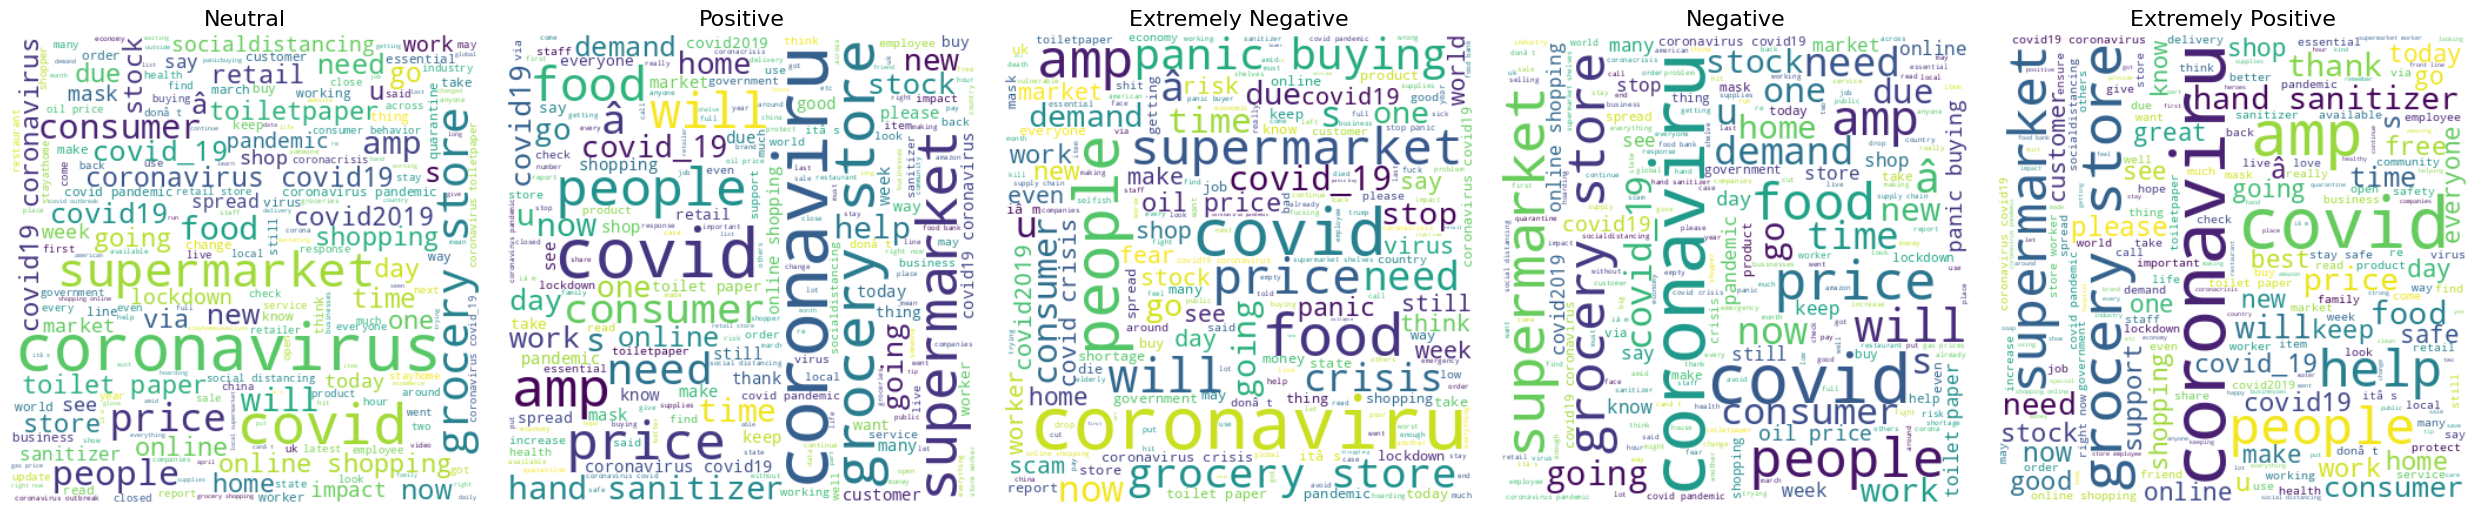

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# lowercasing and basic cleaning
word_cloud_df['clean_text'] = word_cloud_df['OriginalTweet'].str.lower()

# Unique sentiments
sentiments = word_cloud_df['Sentiment'].unique()
to_remove = "http"

def delete_words_with_http(text, to_remove):

    if not isinstance(text, str):
        return text

    words = text.split() #

    kept_words = [word for word in words if to_remove not in word]

    return ' '.join(kept_words) #

word_cloud_df['clean_text'] = word_cloud_df['clean_text'].apply(lambda x: delete_words_with_http(x, to_remove))

# Plot word clouds
fig, axs = plt.subplots(1, len(sentiments), figsize=(5 * len(sentiments), 5))

if len(sentiments) == 1:
    axs = [axs]  # make iterable

for i, sentiment in enumerate(sentiments):
    text_blob = " ".join(word_cloud_df[word_cloud_df['Sentiment'] == sentiment]['clean_text'])
    wordcloud = WordCloud(width=400, height=400, background_color='white', colormap='viridis').generate(text_blob)

    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title(sentiment, fontsize=16)
    axs[i].axis('off')

plt.tight_layout()
plt.show()


The word cloud **did not show** any substantial differances between the topics of tweets under all sentiment categories

In [ ]:
df_temp_indexed = train_df.copy()
df_temp_indexed.sample(8)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
10372,14171,59123,NaN,20-03-2020,What can you do to keep business as usual in...,Negative
13266,17065,62017,Coastal Spain,21-03-2020,Retail analyst Teresa Wickham (of Tunbridge We...,Positive
29727,33526,78478,NYC/LA,05-04-2020,"ÂI go to the grocery store every day,Â says ...",Neutral
32730,36529,81481,Accra,07-04-2020,Hi there To help contain the COVID 19 spread i...,Extremely Positive
32068,35867,80819,"Edinburgh, Scotland",07-04-2020,Coronavirus meme about toilet paper hoarding b...,Neutral
19629,23428,68380,"Silver Spring, MD",24-03-2020,NFHA joined civil rights consumer housing amp ...,Negative
23149,26948,71900,Pakistan,25-03-2020,#Pakistan cuts #petrol prices by Rs15 to Rs96....,Positive
30216,34015,78967,"Regina, Saskatchewan",06-04-2020,Nurses cleaners grocery store clerks amp other...,Positive


In [ ]:
df_temp_indexed['TweetAt'] = pd.to_datetime(df_temp_indexed['TweetAt'])
# ---------------------------------------------------------

df_dt_indexed = df_temp_indexed.copy().set_index('TweetAt')

# המרת סנטימנט לערך מספרי לצורך חישוב ממוצע
sentiment_map = {'Extremely Positive ': 2, 'Positive': 1, 'Neutral': 0, 'Negative': -1, 'Extremely Negative': -2}
df_dt_indexed['Sentiment'] = df_dt_indexed['Sentiment'].map(sentiment_map)
df_dt_indexed.head()


<ipython-input-48-44c04f7c4ca9>:1: UserWarning:

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



,UserName,ScreenName,Location,OriginalTweet,Sentiment
TweetAt,,,,,
2020-03-16,3799,48751,London,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0.0
2020-03-16,3800,48752,UK,advice Talk to your neighbours family to excha...,1.0
2020-03-16,3801,48753,Vagabonds,Coronavirus Australia: Woolworths to give elde...,1.0
2020-03-16,3802,48754,NaN,My food stock is not the only one which is emp...,1.0
2020-03-16,3803,48755,NaN,"Me, ready to go at supermarket during the #COV...",-2.0


In [ ]:
# חישוב ממוצע סנטימנט יומי באמצעות resample.
# הפונקציה resample('D') עובדת על DatetimeIndex ומקבצת את הנתונים לפי יום.
daily_avg_sentiment = df_dt_indexed['Sentiment'].resample('D').mean()

# מילוי ערכים חסרים (NaN) אם יש ימים ללא ציוצים, באמצעות מילוי קדימה (forward fill)
daily_avg_sentiment = daily_avg_sentiment.fillna(method='ffill')
# אפשר גם למלא באפס או בערך אחר: .fillna(0)

print("\nממוצע סנטימנט יומי (ערכים גבוהים יותר = חיובי יותר):")
print(daily_avg_sentiment.head())

# זיהוי אנומליות פשוט: ימים בהם השינוי המוחלט מהיום הקודם גדול מסטיית תקן אחת של השינויים
# (ניתן להתאים את הסף ואת גודל החלון של סטיית התקן)
sentiment_diff=daily_avg_sentiment.diff()
sentiment_diff_abs = daily_avg_sentiment.diff().abs()
# חישוב סף דינמי (לדוגמה, סטיית תקן אחת של ההפרשים, או ערך קבוע)
# נשתמש בחלון מתגלגל לחישוב סטיית תקן כדי שהיא תהיה רלוונטית יותר לשינויים מקומיים, אם כי לסט של הפרשים זה פחות קריטי.
threshold = sentiment_diff_abs.std()
# אם יש מעט נתונים, אפשר לשקול סף קבוע או גישה אחרת.
# לדוגמה, אם threshold יוצא NaN או 0 בגלל מיעוט נתונים/הפרשים, נגדיר סף מינימלי.
if pd.isna(threshold) or threshold == 0:
    threshold = 0.1# ערך ברירת מחדל אם לא ניתן לחשב סטיית תקן משמעותית

anomalies_dates = sentiment_diff_abs[sentiment_diff_abs > threshold].index





ממוצע סנטימנט יומי (ערכים גבוהים יותר = חיובי יותר):
TweetAt
2020-03-16   -0.314183
2020-03-17   -0.365464
2020-03-18   -0.342331
2020-03-19   -0.338456
2020-03-20   -0.386195
Freq: D, Name: Sentiment, dtype: float64


<ipython-input-76-f91908fed8fb>:6: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.




אנומליות חיוביות זוהו בתאריכים:
TweetAt
2020-03-25   -0.194741
2020-03-28    0.000000
2020-03-31   -0.246269
Name: Sentiment, dtype: float64

אנומליות שליליות זוהו בתאריכים:
TweetAt
2020-03-17   -0.365464
2020-03-18   -0.342331
2020-03-19   -0.338456
2020-03-20   -0.386195
2020-03-21   -0.324652
Name: Sentiment, dtype: float64


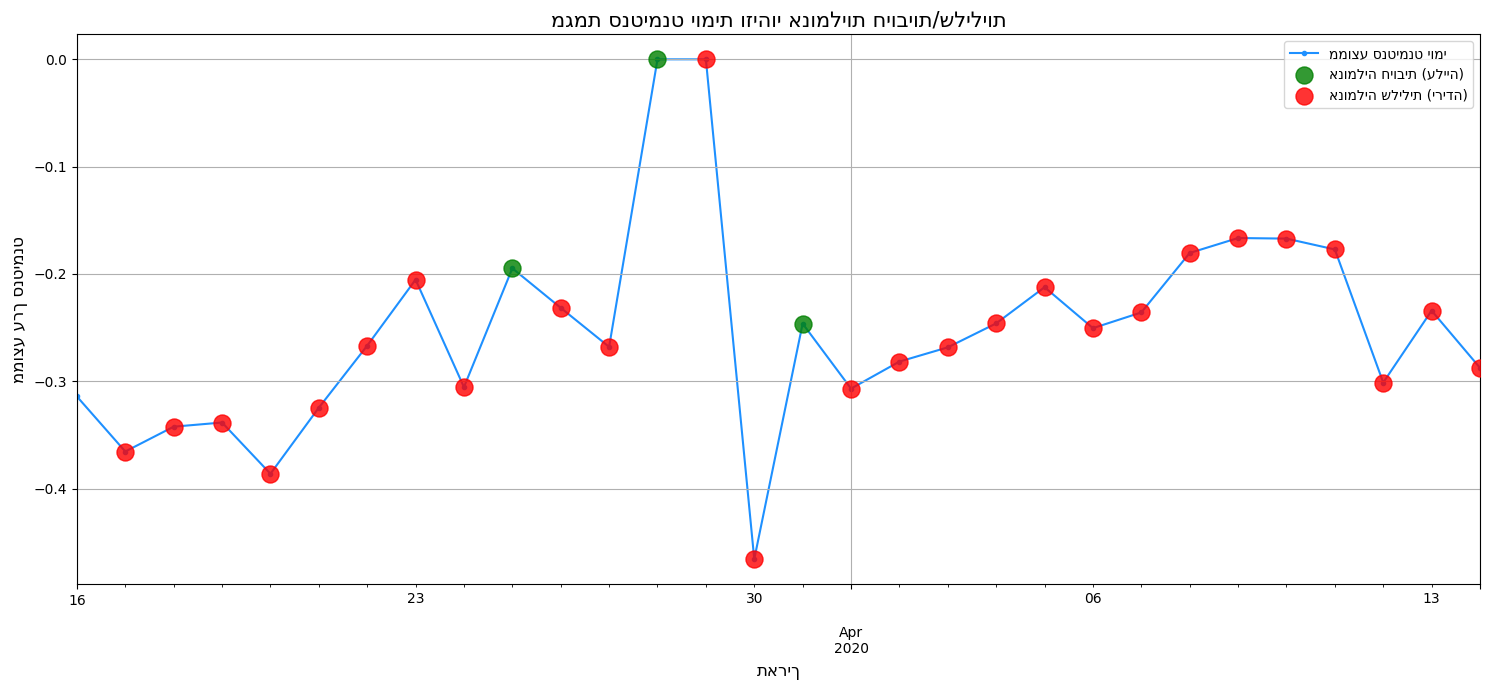

In [ ]:
# זיהוי תאריכים עם אנומליות חיוביות (עלייה חדה)
positive_anomalies_dates = sentiment_diff[sentiment_diff > threshold].index

# זיהוי תאריכים עם אנומליות שליליות (ירידה חדה)
negative_anomalies_dates = sentiment_diff[sentiment_diff <threshold].index

# --- יצירת הגרף ---
plt.figure(figsize=(15,7))
daily_avg_sentiment.plot(label='ממוצע סנטימנט יומי', color='dodgerblue', marker='.', linestyle='-', zorder=1)

# הדפסת האנומליות החיוביות
if not positive_anomalies_dates.empty:
    valid_positive_dates = [date for date in positive_anomalies_dates if date in daily_avg_sentiment.index]
    if valid_positive_dates:
        plt.scatter(valid_positive_dates, daily_avg_sentiment.loc[valid_positive_dates],
                    color='green', s=150, label='אנומליה חיובית (עלייה)', zorder=5, alpha=0.8)
        print("\nאנומליות חיוביות זוהו בתאריכים:")
        print(daily_avg_sentiment.loc[valid_positive_dates])
else:
    print("\nלא זוהו אנומליות חיוביות משמעותיות.")

# הדפסת האנומליות השליליות
if not negative_anomalies_dates.empty:
    valid_negative_dates = [date for date in negative_anomalies_dates if date in daily_avg_sentiment.index]
    if valid_negative_dates:
        plt.scatter(valid_negative_dates, daily_avg_sentiment.loc[valid_negative_dates],
                    color='red', s=150, label='אנומליה שלילית (ירידה)', zorder=5, alpha=0.8)
        print("\nאנומליות שליליות זוהו בתאריכים:")
        print(daily_avg_sentiment.loc[valid_negative_dates].head())
else:
    print("\nלא זוהו אנומליות שליליות משמעותיות.")

plt.title('מגמת סנטימנט יומית וזיהוי אנומליות חיוביות/שליליות', fontsize=15)
plt.xlabel('תאריך', fontsize=12)
plt.ylabel('ממוצע ערך סנטימנט', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()